# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 2 : Optimisation - DataScience Master
    Authors : Robert Gower, Alexandre Gramfort, Pierre Ablin, Mathurin Massias, Nidham Gazagnadou
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


## <font color='red'>VERY IMPORTANT: if some of the following instructions is not followed, it will be penalized</font>

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 27th of november at 21:55**, using the **moodle platform**.
- Only **one submission by pair** of students
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [0]:
# Change here using YOUR first and last names
fn1 = "alhousseynou"
ln1 = "ball"
fn2 = "bakary"
ln2 = "sidibe"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab2", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab2_ball_alhousseynou_and_sidibe_bakary.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[0. Test Numba](#numba)<br>
[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [0]:
%matplotlib inline

In [0]:
from time import time

import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
import numba # available at: http://numba.pydata.org/numba-doc/latest/user/installing.html
from numba import njit


In [0]:
# choose a large font size by default and use tex for math
usetex = False # change this to True if you have a working LaTeX install

fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': usetex}
plt.rcParams.update(params)

<a id='numba'></a>
## 0. Make sure Numba is correctly installed
Instructions available at: http://numba.pydata.org/numba-doc/latest/user/installing.html

In [0]:
print(numba.__version__) # Your version of Numba

0.40.1


In [0]:
@njit
def go_fast(a): # Function is compiled to machine code when called the first time
    trace = 0
    # assuming square input matrix
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting

x = np.arange(100).reshape(10, 10)
go_fast(x); # Running a first time the function to compile it

Iteration time of the Numba-compiled function.

In [0]:
%timeit go_fast(x)

The slowest run took 29.63 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 810 ns per loop


Numba-compiled function have a special `.py_func` attribute which is the original uncompiled Python function.  Iteration time of the uncompiled function should be greater.

In [0]:
%timeit go_fast.py_func(x)

The slowest run took 5.67 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 22.7 µs per loop


<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for linear regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [0]:
@njit    
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    n, _ = A.shape
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    return g / n


def loss_linreg(x, A, b, lbda):
    n, _ = A.shape
    return norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * norm(x) ** 2 / 2.


def lipschitz_linreg(A, b, lbda):
    n, _ = A.shape
    return norm(A, ord=2) ** 2 / n + lbda

In [0]:
@njit    
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    n, _ = A.shape
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.


def lipschitz_logreg(A, b, lbda):
    n, _ = A.shape
    return norm(A, ord=2) ** 2 / (4. * n) + lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [0]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [0]:
def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [0]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


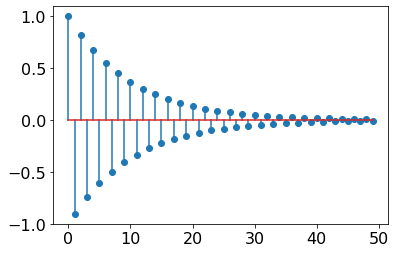

In [0]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [0]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

1.744104586592136e-06

In [0]:
lbda = 1. / n ** (0.5)

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

2.227925675210063e-07

### Choice of the model

In [0]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)

### Compute the theoretical step-size for gradient descent

In [0]:
step = 1. / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.06417110934642879


### Get a very precise minimum to compute distances to minimum

In [0]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)


print(f_min)
print(norm(grad_linreg(x_min, A, b, lbda)))

0.5193790569795882
1.000655409042807e-08


<a id='batch'></a> 

## 3. Deterministic/Batch methods (GD, AGD, BFGS)

### Define a class to monitor iterations

In [0]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [0]:
# Number of full batch iterations
n_iter = 50

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Q1) Fill in the iteration of the GD solver in the cell below

In [0]:
@njit
def gd(x_init, grad, n_iter=100, step=1., store_every=1, args=()):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        x = x - step * grad(x, args[0], args[1], args[2])
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [0]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Q2) Fill in the iteration of the AGD solver in the cell below

In [0]:
@njit
def agd(x_init, grad, n_iter=100, step=1., args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        if i % store_every == 0:
            x_list.append(x.copy())
        ### TODO
        x_new = y - step * grad(y, args[0], args[1], args[2])
        t_new = (1 + np.sqrt(1 + 4 * t ** 2)) / 2
        y = x_new + (t - 1) / t_new * (x_new - x)
        t = t_new
        x = x_new

        ### END TODO
    return x, x_list

In [0]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### scipy.optimize's L-BFGS

Let's compare with ``scipy.optimize``'s L-BFGS solver

In [0]:
class callback():
    def __init__(self):
        self.x_list = []
    
    def __call__(self, x):
        self.x_list.append(x.copy())
        
        
def scipy_runner(scipy_algo):
    def run(*args, **kwargs):
        cb = callback()
        x = scipy_algo(*args, **kwargs, callback=cb)
        return x, cb.x_list
    return run

In [0]:
# L-BFGS algorithm
from scipy.optimize import fmin_l_bfgs_b


x_init = np.zeros(d)

monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [0]:
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers)
    

def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

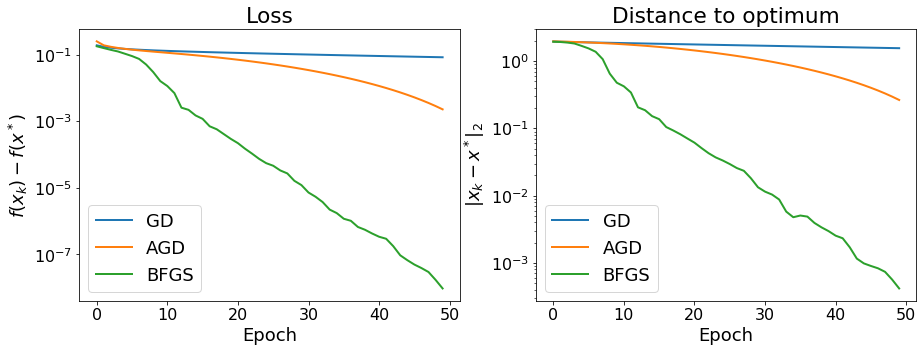

In [0]:
monitors = [monitor_gd, monitor_agd, monitor_bfgs]

solvers = ["GD", "AGD", "BFGS"]

plot_epochs(monitors, solvers)

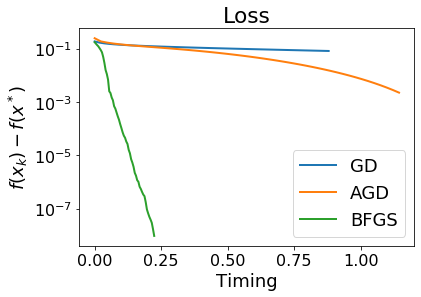

In [0]:
plot_time(monitors, solvers)

### First conclusions

*QUESTIONS*:

- Q3) Give some first conclusions about the batch solver studied here

> The graphs above (loss function) make it possible to have a global idea about the speed of convergence of the different deterministic models.
- First, we find that among the three algorithms, the L-BFGS algorithm (Broyden - Fletcher - Goldfarb - Shanno) is the best technique in terms of speed of convergence. Indeed, after 50 epochs, the distance to the optimum is less than 10 $ ^ {- 3} $ i.e $ | x_k - x ^ * | < 10 ^ {- 3} $. By the way, $ f (x_k) $ converges almost to $ f (x *) $ after 0.3 seconds.  But it stops earlier
- Second, the GD algorithm is the slowest in terms of convergence to the minimum, when compared to the L-BFGS and AGD models.

- Q4) What do you observe about AGD? is it suprising ?

> The AGD algorithm converges faster than the simple descent algorithm. This result is indeed coherent. Therefore, the simple gradient (GD) algorithm has $ \frac{1}{t} $ as convergence rate, whereas the convergence of the algorithm AGD is $ \frac {1}{t ^ 2} $ . So, it's no surprising that the AGD converges faster than the simple GD.


<a id='stoc'></a> 
## 4. Stochastic methods
*WARNING*: for stochastic methods ``n_iter`` corresponds to the number of epochs (number of full pass across the data)

In [0]:
n_iter = 50 # here corresponds to the number of epochs

# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Q5) Fill in the iteration of the SGD solver in the cell below

In [0]:
@njit
def sgd(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        x = x - step * grad_i(i, x, args[0], args[1], args[2]) / np.sqrt( idx + 1)
        ### END TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [0]:
step0 = 1e-1
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, iis, grad_i, n_iter * n, step0, args=(A, b, lbda))

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Q6) Fill in the iteration of the SAG solver in the cell below

In [0]:
@njit
def sag(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    n, d = args[0].shape
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    averaged_gradient = np.zeros(d)
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        grad_i_new  = grad_i(i, x, args[0], args[1], args[2])
        averaged_gradient += (grad_i_new - gradient_memory[i]) / n
        x = x - step *  averaged_gradient
        gradient_memory[i] = grad_i_new
        ### END OF TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [0]:
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)

x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, iis, grad_i, n_iter * n, step, args=(A, b, lbda))

### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Q7) Fill in the iteration of the SVRG solver in the cell below

In [0]:
@njit
def svrg(x_init, iis, grad, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    x_list = []
    for idx in range(n_iter):
        
        ### TODO
        if idx % store_every == 0:
          x_old = x
          u_k = grad(x_old, args[0], args[1], args[2])
       
        i = iis[idx]  
        x = x - step * (grad_i(i, x, args[0], args[1], args[2]) - grad_i(i, x_old, args[0], args[1], args[2]) + u_k)
        ### END TODO        
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [0]:
x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, iis, grad, grad_i, n_iter * n, step, args=(A, b, lbda))

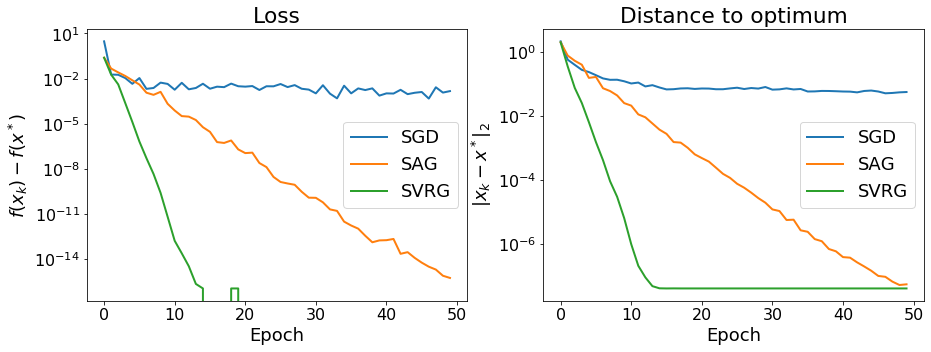

In [0]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

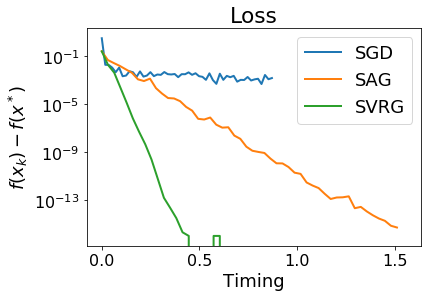

In [0]:
plot_time(monitors, solvers)

### First conclusions

*QUESTIONS*:

- Q8) Compare the converge (on the different plots) of the stochastic methods you implemented

<a id='comp'></a> 
## 5. Numerical comparison

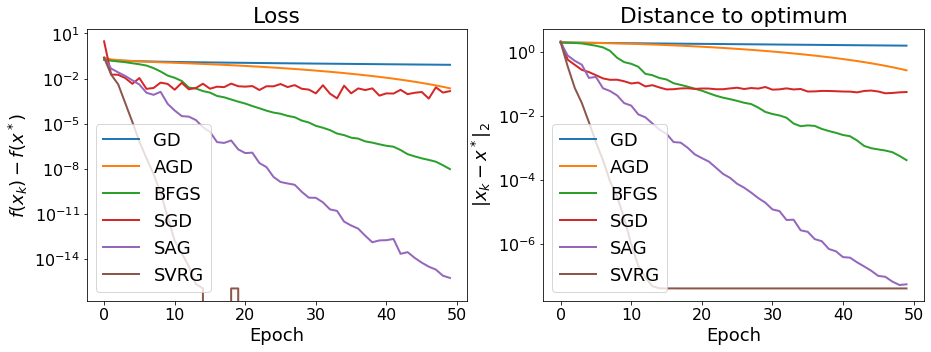

In [0]:
monitors = [monitor_gd, monitor_agd, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "BFGS", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

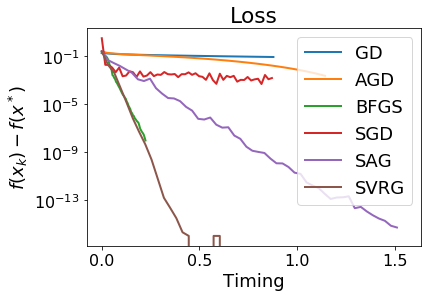

In [0]:
plot_time(monitors, solvers)

<a id='conc'></a>
## 6. Conclusion

- Q9) Compare the deterministic and the stochastic gradient methods. Comment your results.

> From the results above we see that: the two stochastic methods, **SVRG** and **SAG** are the fastest compared to the other methods.
SVRG is faster than SAG here, because it requires less time to store data: only one gradient: $O(d)$ instead of the n previous gradients for SAG : $O(nd)$

> We can also see that the deterministic method, L-BFGS converges faster than the one of the stochastic, SGD. 
But compared to SGD, L-BFGS is more computionally expensive and requires more memory, because it needs to approximate the Hessian matrix and stores more search information. L-BFGS can also use larger mini-batch sizes, which results in lowered computation cost per epoch.


- Q10) Change the value of the ridge regularization (the lbda parameter) to low ridge  $\lambda=\frac{1}{n}$   and high ridge regularization  $\lambda=\frac{1}{\sqrt n}$  and compare your results. Comment.

In [0]:

def optimization_algo(args=()):
  '''
  input : args=(A, b, lbda)
  output : monitors, solvers
  '''
  # New parameters
  x_init = np.zeros(d)
  step = 1. / lipschitz_linreg(args[0], args[1], args[2])
  x_min, _, _ = fmin_l_bfgs_b(loss, x_init, grad, args=args, pgtol=1e-30, factr=1e-30)
  iis = np.random.randint(0, n, n * n_iter)

  # GD algorithm
  monitor_gd = monitor(gd, loss, x_min, args)
  monitor_gd.run(x_init, grad, n_iter, step, args=args)

  # AGD algorithm
  monitor_agd = monitor(agd, loss, x_min, args)
  monitor_agd.run(x_init, grad, n_iter, step, args=args)

  # L-BFGS algorithm
  monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, args)
  monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=args, pgtol=1e-30)

  # SGD algorithm
  monitor_sgd = monitor(sgd, loss, x_min, args)
  monitor_sgd.run(x_init, iis, grad_i, n_iter * n, step0, args=args)

  # SAG algorithm
  max_squared_sum = np.max(np.sum(args[0] ** 2, axis=1))
  step = 1.0 / (max_squared_sum + args[2])
  monitor_sag = monitor(sag, loss, x_min, args)
  monitor_sag.run(x_init, iis, grad_i, n_iter * n, step, args=args)

  # SVRG algorithm
  monitor_svrg = monitor(svrg, loss, x_min, args)
  monitor_svrg.run(x_init, iis, grad, grad_i, n_iter * n, step, args=args)


  # Plot
  monitors = [monitor_gd, monitor_agd, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

  solvers = ["GD", "AGD", "BFGS", "SGD", "SAG", "SVRG"]
  return monitors, solvers


In [0]:
A, b = simu_linreg(x_model_truth, n, std=1.0, corr=0.9)

# save values for lambda = 1/n
lbda = 1. / n
args = (A, b, lbda)
monitors_lbda1, solvers_lbda1 = optimization_algo(args)

# save values for lambda = 1/sqrt(n)
lbda = 1. / n ** (0.5)
args = (A, b, lbda)
monitors_lbda2, solvers_lbda2 = optimization_algo(args)


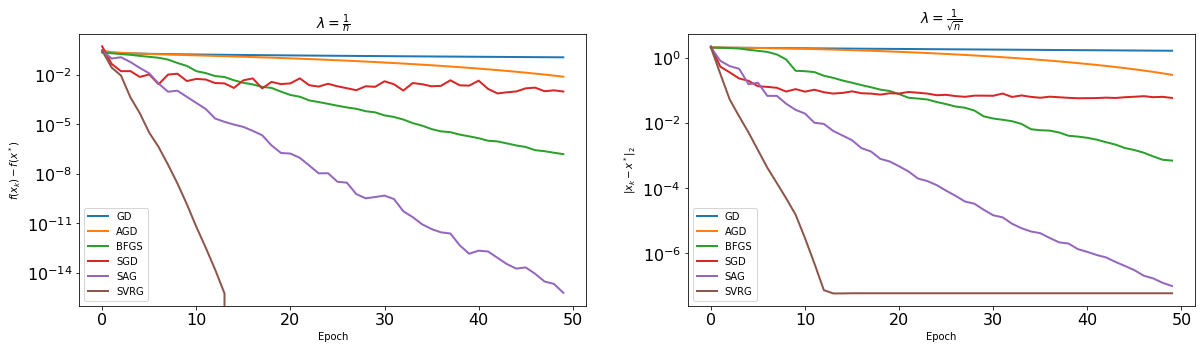

In [0]:
# Plotting the different values lambda : lbda 
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
# lambda = 1/n
for monit in monitors_lbda1:
    plt.semilogy(monit.obj, lw=2)
    plt.title(r'$\lambda=\frac{1}{n}$', fontsize=14)
    plt.xlabel("Epoch", fontsize=10)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=10)

plt.legend(solvers_lbda1, fontsize=10)

plt.subplot(1, 2, 2)
# lambda = 1/sqrt(n)
for monit in monitors_lbda2:
    plt.semilogy(monit.err, lw=2)
    plt.title(r'$\lambda=\frac{1}{\sqrt{n}}$', fontsize=14)
    plt.xlabel("Epoch", fontsize=10)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=10)

plt.legend(solvers_lbda2, fontsize=10)
plt.show()

> When the value of the ridge regularization (i.e $\lambda $ ) is low, the algorithms converge much more quickly.










- Q11) Look carefuly on how the data are generated in functions simu_linreg and simu_logreg. Play also with the level of correlation between features (parameter corr above), and compare results with low and high correlation.

In [0]:
lbda = 1. / n ** (0.5)

# save values linear regression low correlation : corr = 0.1
A, b = simu_linreg(x_model_truth, n, std=1.0, corr=0.1)
args = (A, b, lbda)
monitors_llow, solvers_llow = optimization_algo(args)

# save values linear regression high correlation : corr = 0.9
A, b = simu_linreg(x_model_truth, n, std=1.0, corr=0.9)
args = (A, b, lbda)
monitors_lhigh, solvers_lhigh = optimization_algo(args)

# save values logistic regression low correlation : corr = 0.1
A, b = simu_logreg(x_model_truth, n, std=1.0, corr=0.1)
args = (A, b, lbda)
monitors_rlow, solvers_rlow = optimization_algo(args)

# save values logistic regression high correlation : corr = 0.9
A, b = simu_logreg(x_model_truth, n, std=1.0, corr=0.9)
args = (A, b, lbda)
monitors_rhigh, solvers_rhigh = optimization_algo(args)

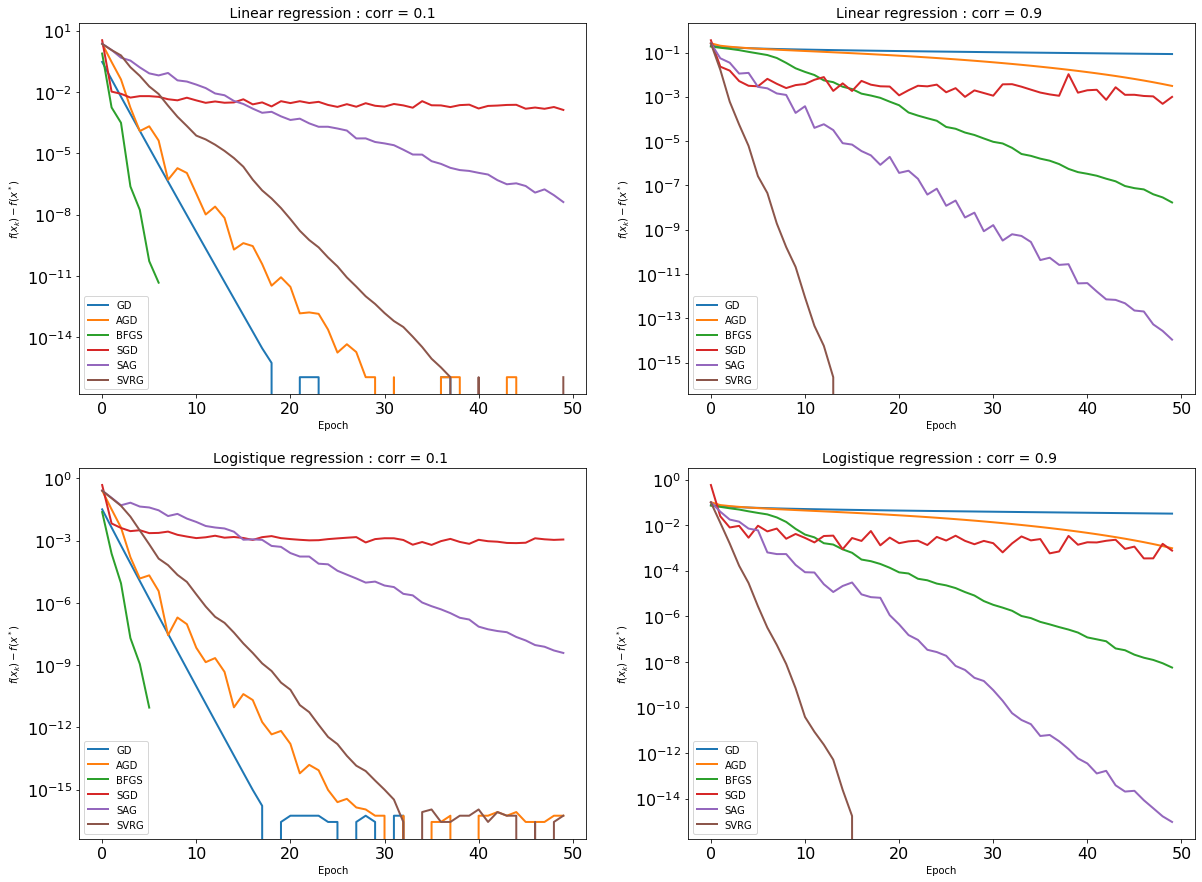

In [0]:
# Plotting the different values correlation : corr 
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)

# linear regression low correlation : corr = 0.1
for monit in monitors_llow:
    plt.semilogy(monit.obj, lw=2)
    plt.title(" Linear regression : corr = 0.1 ", fontsize=14)
    plt.xlabel("Epoch", fontsize=10)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=10)
plt.legend(solvers_llow, fontsize=10)
plt.subplot(2, 2, 2)

# linear regression high correlation : corr = 0.9
for monit in monitors_lhigh:
    plt.semilogy(monit.obj, lw=2)
    plt.title("Linear regression : corr = 0.9 ", fontsize=14)
    plt.xlabel("Epoch", fontsize=10)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=10)
plt.legend(solvers_lhigh, fontsize=10)
plt.subplot(2, 2, 3)

# logistic regression low correlation : corr = 0.1
for monit in monitors_rlow:
    plt.semilogy(monit.obj, lw=2)
    plt.title("Logistique regression : corr = 0.1 ", fontsize=14)
    plt.xlabel("Epoch", fontsize=10)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=10)

plt.legend(solvers_rlow, fontsize=10)
plt.subplot(2, 2, 4)

# logistic regression high correlation : corr = 0.9
for monit in monitors_rhigh:
    plt.semilogy(monit.obj, lw=2)
    plt.title("Logistique regression : corr = 0.9 ", fontsize=14)
    plt.xlabel("Epoch", fontsize=10)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=10)

plt.legend(solvers_rhigh, fontsize=10)

plt.show()

> The correlation between features is an important criterion to choose algorithms. Indeed, the fact of varying the value of the correlation the convergence of the different algorithms changes. With a high correlation, stochastic methods give the best results because they avoid being stuck in local extrema. Thus, SVRG seems to be the best choice. However, when the correlation is low, the deterministic methods are the best, because each function of the cost function is really significant and therefore converges more quickly. L-BFGS seems to be the best choice.

- Q12) Change the number of data points  n  and the number of data samples  d  and compare your results. Comment.

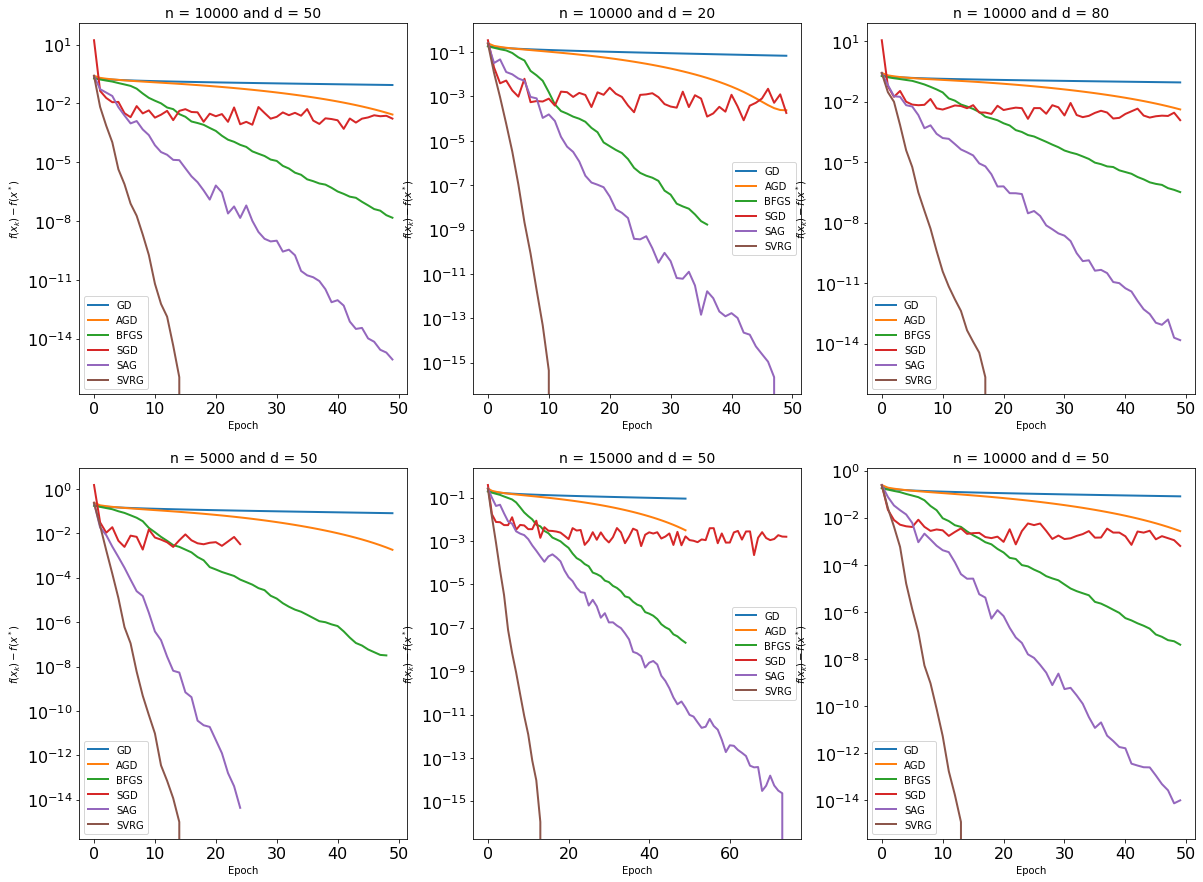

In [0]:
# Plotting : Graph reference is n = 10000 an d = 50
n_list = [10000, 10000, 10000, 5000, 15000, 10000]  # values of data points n
d_list = [50, 20, 80, 50, 50, 50]                   # values of data samples d
index = [1, 2, 3, 4, 5, 6]                          # index for plt.subplot
plt.figure(figsize=(20, 15))
for n, d, indice in zip(n_list, d_list, index):  
  idx = np.arange(d)
  # generate indices of random samples
  iis = np.random.randint(0, n, n * n_iter)

  # Ground truth coefficients of the model
  x_model_truth = (-1)**idx * np.exp(-idx / 10.)

  A,b = simu_linreg(x_model_truth, n, std=1., corr=0.9)
  lbda = 1/ n**(0.5)
  args = (A, b, lbda)
  monitors, solvers = optimization_algo(args)
  plt.subplot(2, 3, indice)
  for monit in monitors:
    plt.semilogy(monit.obj, lw=2)
    plt.title("n = {} and d = {}".format(n ,d), fontsize=14)
    plt.xlabel("Epoch", fontsize=10)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=10)

  plt.legend(solvers, fontsize=10)


> From the results above we get: \\
For low d , the stochastic methods converge faster to in higher d. And the convergence of deterministic methods doesn't change. \\
When we increase n (n = 15000), svrg algorithm converges faster than when n = 10000. In all three cases (ie n = 5000, 10000, 15000), the SVRG is still better and more stable compared to others

- Q13) Conclude on the performance on the implemented methods. Are their "regimes" for which some methods are faster than others?

> Models converge quickly when the ridge regularization parameter value is low.
 In particular, deterministic methods perform better when the correlation of the data is weak.
Stochastic methods perform better when the correlation of the data is strong.

- Q14) Are there different behaviours between the deterministic methods? What about the stochastic ones?

> From the results above, the deterministic methods beahve similarly (linearly congergence) because the iteration complexity in deterministic methods is linear in n whereas stochastic methods oscillate toward the minimum and the iteration complexity is independent in n

- Q15) Compare the memory, the number of hyper-parameters to tune and the ease of implementation of each algorithm. According to this, in which configuration do you think a user should use deterministic method rather than a stochastic one, and vice-versa?

> From our results we notice that, SGD has a small memory footprint, learns quickly, and it is robust to noise. But one of the main weaknesses of SGD is the imprecision of the stochastic gradients. The problem is that gradients tend to bounce around in varying directions, so instead of smoothly approaching our converged error, we will tend to jitter

> The algorithms SVRG and SAG require that an entire epoch’s worth of gradients be stored. This can be very cheap in the case of logistic or linear regression as we only need to save a single variable as the gradient. In most models, however, we increase our memory requirement by the size of the training data.

> When the training set is large, stochastic methods are preferred over
the deterministic methods. But the deterministic methods are prefered over the stochastic ones when we have low correlation 